In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from scipy.linalg import pinv
from time import time

from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA, TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, silhouette_samples, mean_squared_error
from sklearn.random_projection import GaussianRandomProjection
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import scale
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from numpy import linalg as LA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

import itertools

import time

import warnings
warnings.filterwarnings('ignore')

seed = 123

In [55]:

bc = load_breast_cancer()
db = pd.read_csv('./data/diabetes.csv')

selected_dataset = db

if selected_dataset is bc:
    X = bc.data
    y = bc.target
    df = pd.DataFrame(data=X, columns=bc.feature_names)
    df['label'] = y
else:
    df = db
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

X =  scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = seed)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(537, 8) (537,)
(115, 8) (115,)
(116, 8) (116,)


#### 1. Run the clustering algorithms on the datasets and describe what you see.

K-Means

In [18]:
set_range = range(2,10)

def KMeans_plot(name, X):
    interia = []
    scores = []
    for i in set_range:
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state = seed)
        kmeans.fit(X)
        interia.append(kmeans.inertia_)
        
        preds = kmeans.predict(X)
        scores.append(silhouette_score(X, preds))
                
    plt.plot(set_range, interia)
    plt.title("Inertia vs. Number of Clusters")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia (Sum Square Error)')
    plt.tight_layout()
    plt.grid()
    plt.show()
    
    plt.plot(set_range, scores, color = 'grey')
    plt.title("Silhouette Score vs. Number of Clusters")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.grid()
    plt.show()
            

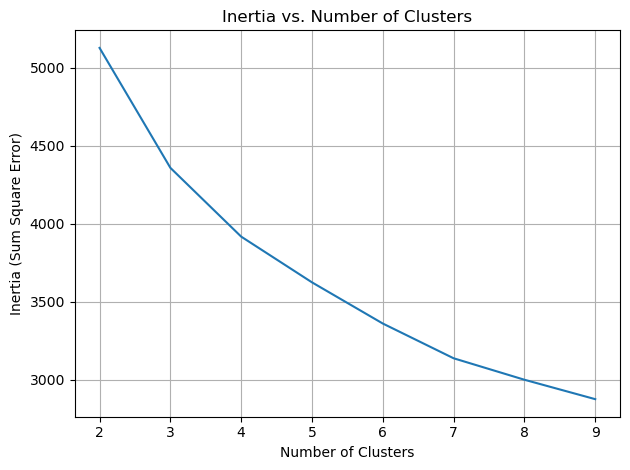

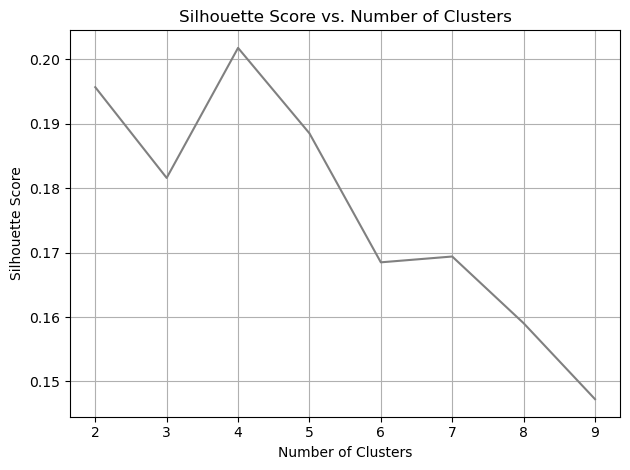

In [19]:
KMeans_plot('Wisconsin Breast Cancer', X )

In [56]:
range_n_clusters = [2, 3, 4, 5]
def clustering_plots(cluster_model=KMeans):
    for n_clusters in range_n_clusters:
        if cluster_model== KMeans:
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(18, 7)
            ax1.set_xlim([-0.1, 1])
            ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        else:
            fig, ax1 = plt.subplots(1, 1)
            ax1.set_xlim([-0.1, 1])
            ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
            
        if cluster_model == KMeans:
            clusterer = cluster_model(n_clusters=n_clusters, random_state=seed)
            cluster_labels = clusterer.fit_predict(X)
        else:
            clusterer = cluster_model(n_components=n_clusters, covariance_type='full')
            cluster_labels = clusterer.fit_predict(X)


        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )
            
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        if cluster_model == KMeans:
            # 2nd Plot showing the actual clusters formed
            colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
            ax2.scatter(
                X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
            )

            # Labeling the clusters
            centers = clusterer.cluster_centers_
            # Draw white circles at cluster centers
            ax2.scatter(
                centers[:, 0],
                centers[:, 1],
                marker="o",
                c="white",
                alpha=1,
                s=200,
                edgecolor="k",
            )

            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

            ax2.set_title("The visualization of the clustered data")
            ax2.set_xlabel("Feature space for the 1st feature")
            ax2.set_ylabel("Feature space for the 2nd feature")

            plt.suptitle(
                "Silhouette analysis on sample data with n_clusters = %d"
                % n_clusters,
                fontsize=14,
                fontweight="bold",
            )
            plt.show()
        else:
            pass

For n_clusters = 2 The average silhouette_score is : 0.1956540901138544


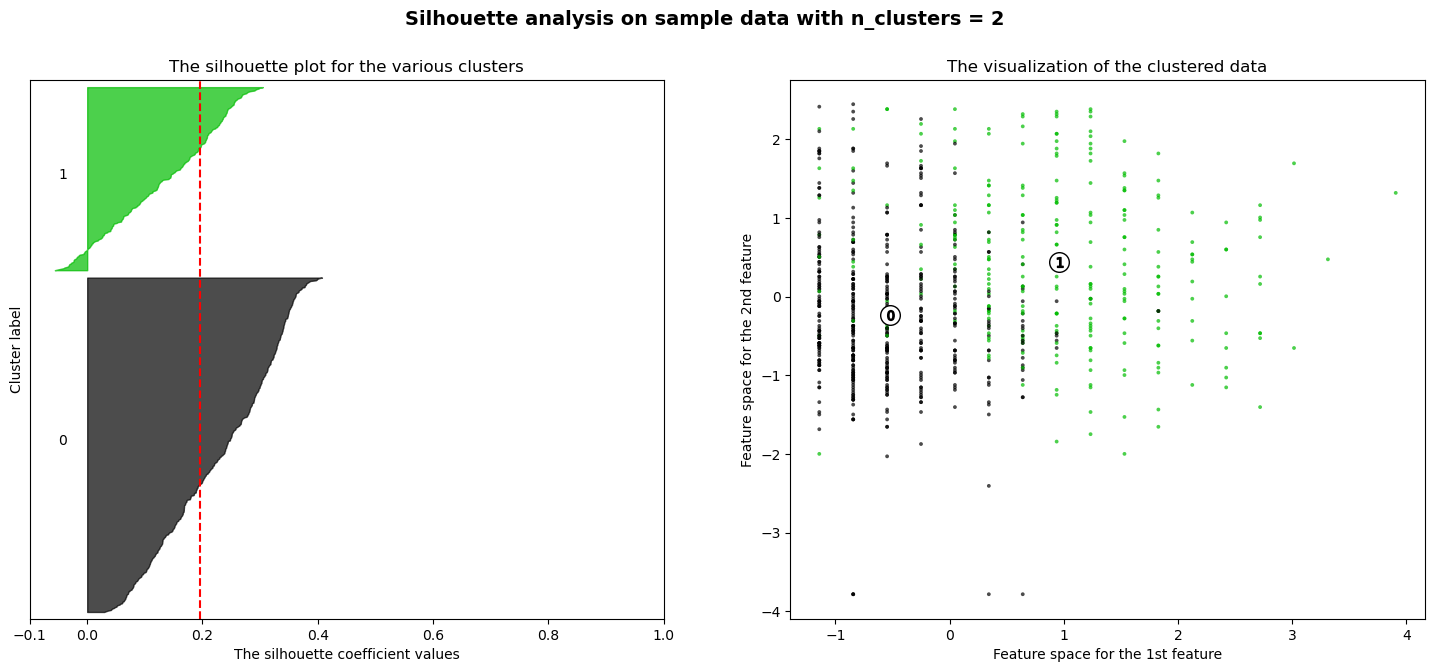

For n_clusters = 3 The average silhouette_score is : 0.18157758712847727


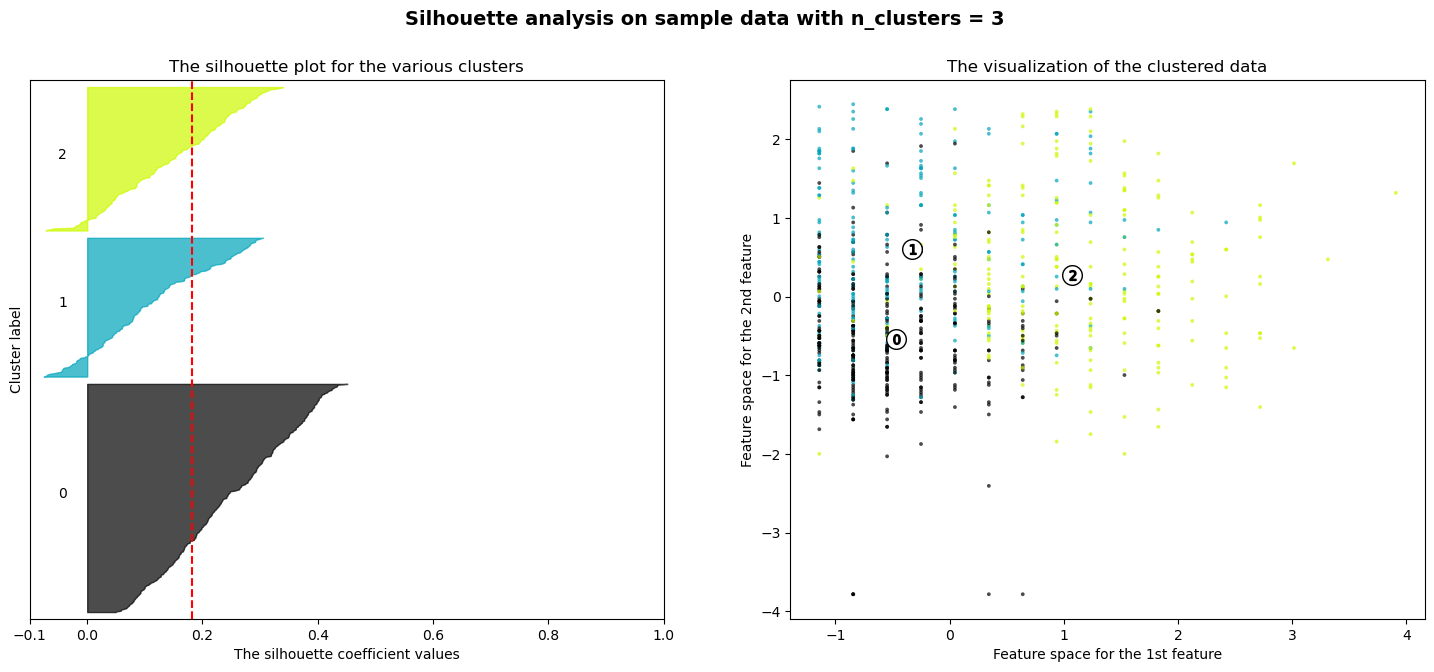

For n_clusters = 4 The average silhouette_score is : 0.20174890536020604


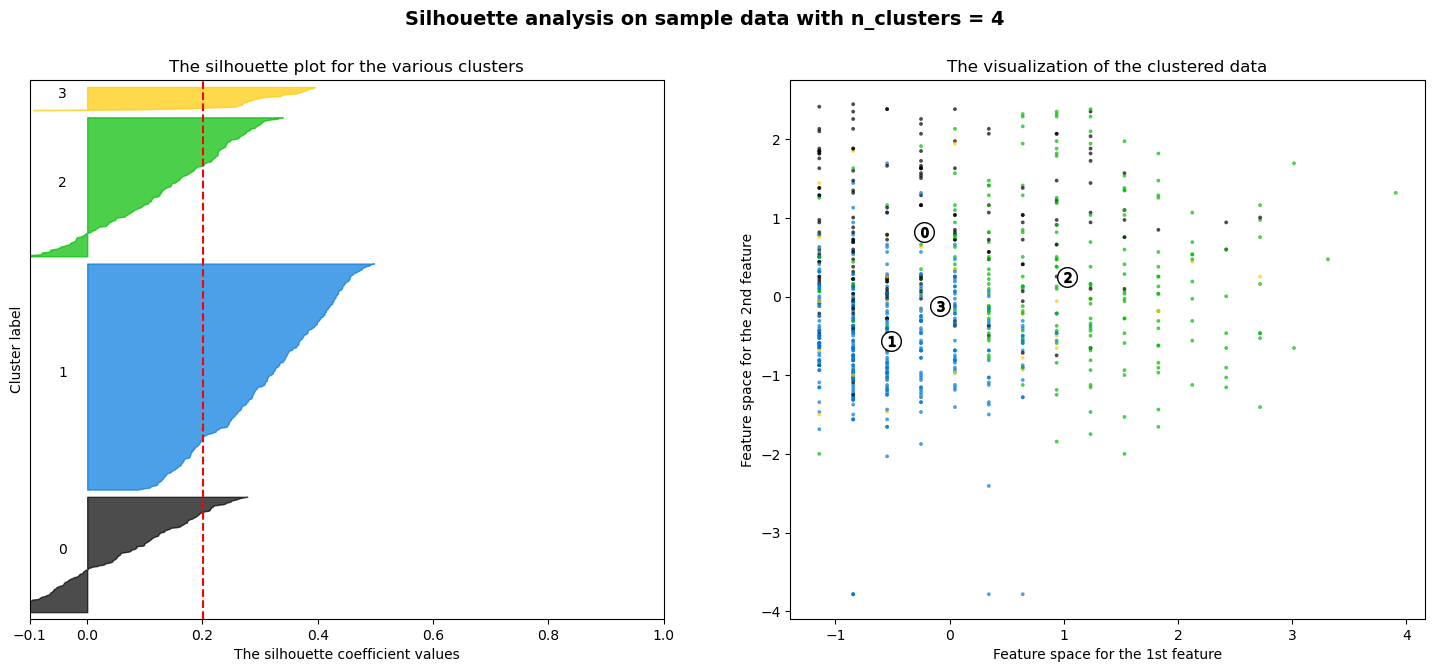

For n_clusters = 5 The average silhouette_score is : 0.188495530702822


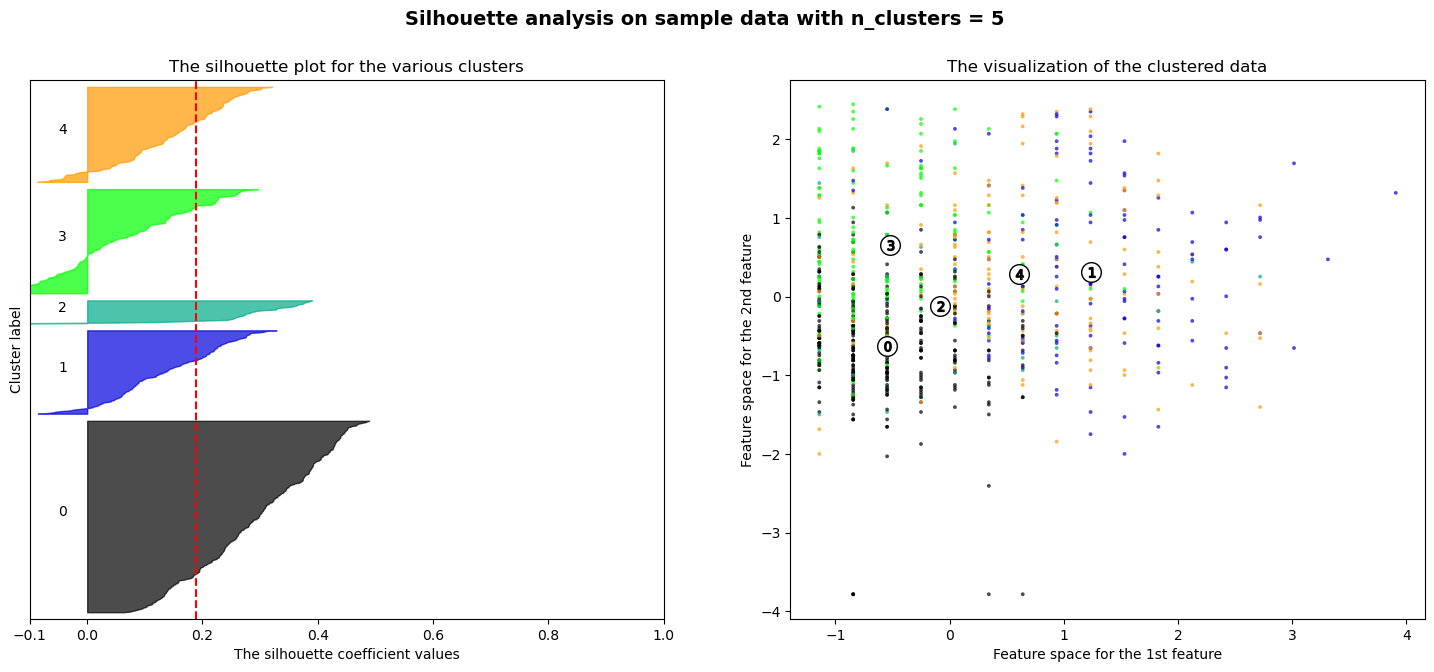

For n_clusters = 6 The average silhouette_score is : 0.168483074625017


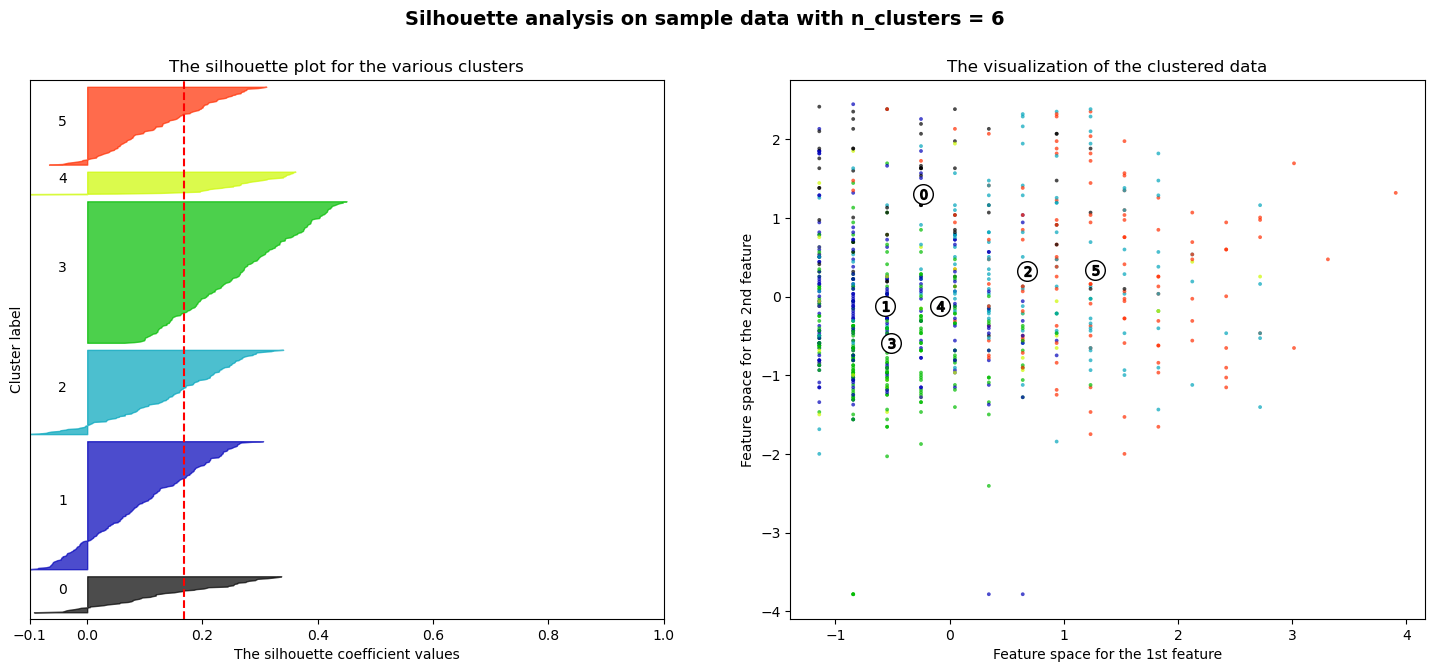

In [29]:
clustering_plots(cluster_model=KMeans)

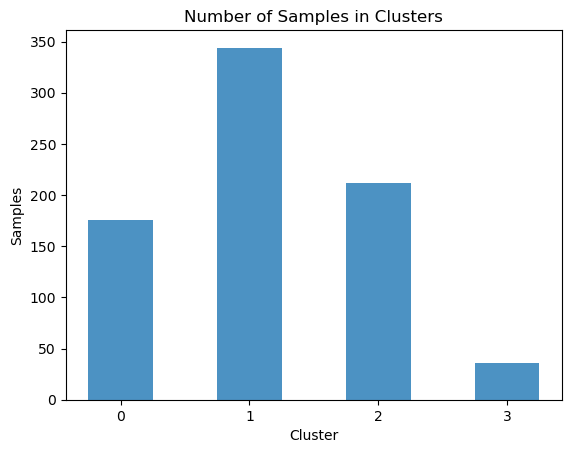

In [30]:
n = 4
k_means_clustering = KMeans(n_clusters=n, random_state=seed)
k_means_clustering.fit(X)
plt.figure()
plt.grid()
plt.hist(k_means_clustering.labels_, bins=np.arange(0, n + 1) - 0.5, rwidth=0.5, zorder=2, alpha=0.8)
plt.xticks(np.arange(0, n))
plt.xlabel('Cluster')
plt.ylabel('Samples')
plt.title('Number of Samples in Clusters')
plt.grid()

EM

In [57]:
def em_plot(X):
    aic, bic, scores = [], [], []
    for i in set_range:
        gmm = GaussianMixture(n_components=i, random_state=0)
        gmm.fit(X)
        aic.append(gmm.aic(X))
        bic.append(gmm.bic(X))
        
        gmm_labels = gmm.predict(X)
        scores.append(silhouette_score(X, gmm_labels))
                
    # Plot the data
    plt.figure(figsize=(10, 8))
    
    plt.subplot(311)
    plt.plot(set_range, aic,  label='AIC')
    plt.title("Scores vs. Number of Clusters")
    plt.xlabel('Number of Clusters')
    plt.legend()
    # plt.ylabel('AIC')
    # plt.grid()
    
    # plt.subplot(312)
    plt.plot(set_range, bic, label='BIC')
    # plt.title("BIC Score vs. Number of Clusters")
    plt.xlabel('Number of Clusters')
    plt.legend()
    plt.tight_layout()
    plt.grid()
    # plt.ylabel('BIC')
    # plt.grid()
    
    plt.subplot(312)
    plt.plot(set_range, scores, color = 'grey')
    plt.title("Silhouette Score vs. Number of Clusters")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.grid()
    plt.show()

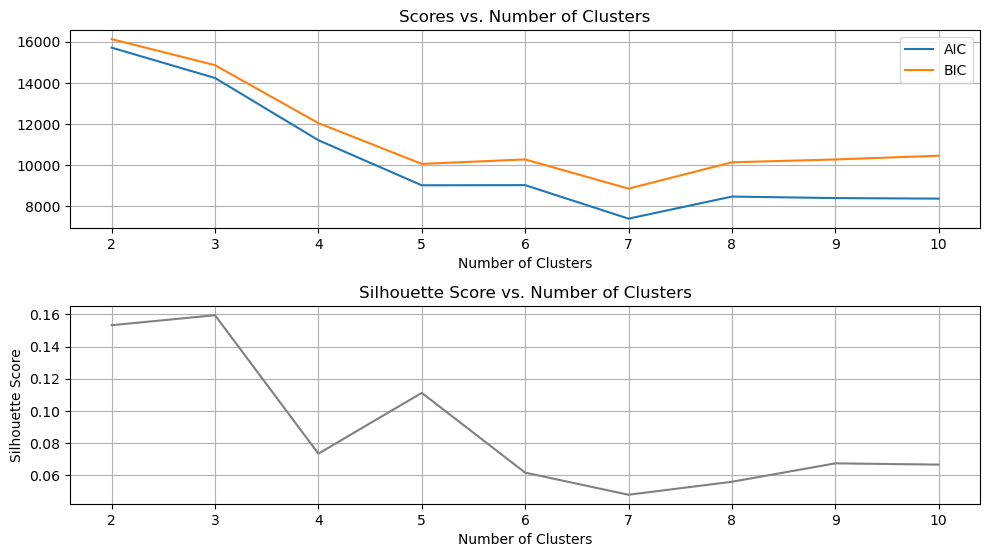

In [58]:
set_range = range(2, 11)
em_plot(X)

For n_clusters = 2 The average silhouette_score is : 0.15283972001295934
For n_clusters = 3 The average silhouette_score is : 0.1595106185224052
For n_clusters = 4 The average silhouette_score is : 0.06631974237669201
For n_clusters = 5 The average silhouette_score is : 0.14427751538830502


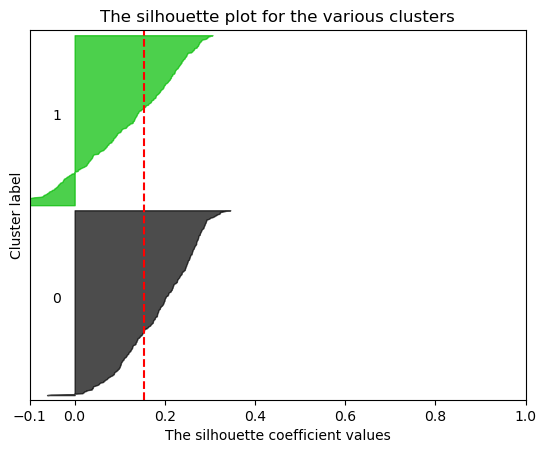

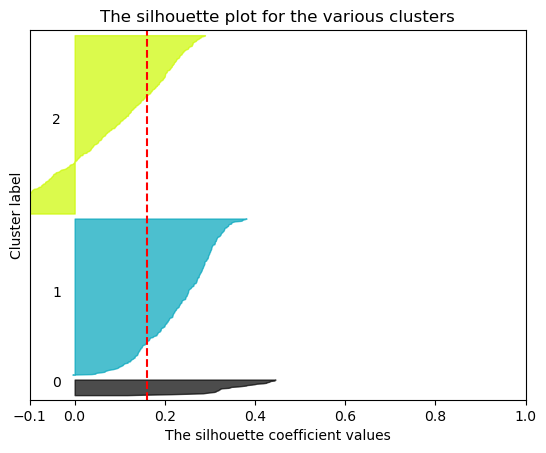

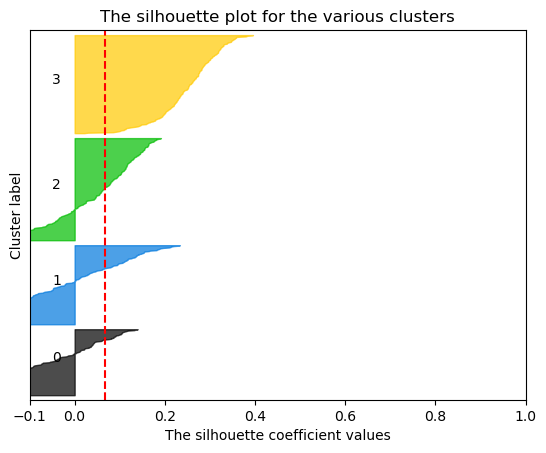

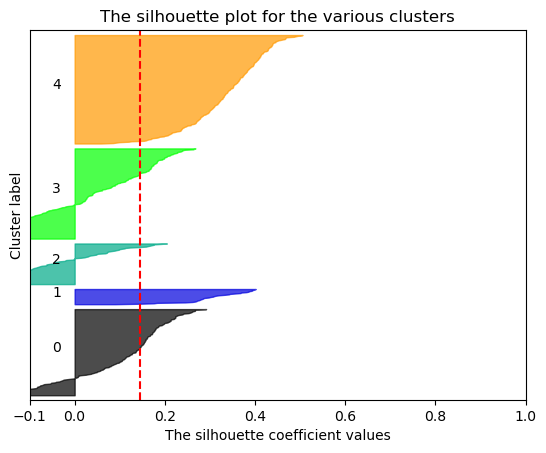

In [60]:
clustering_plots(cluster_model=GaussianMixture)

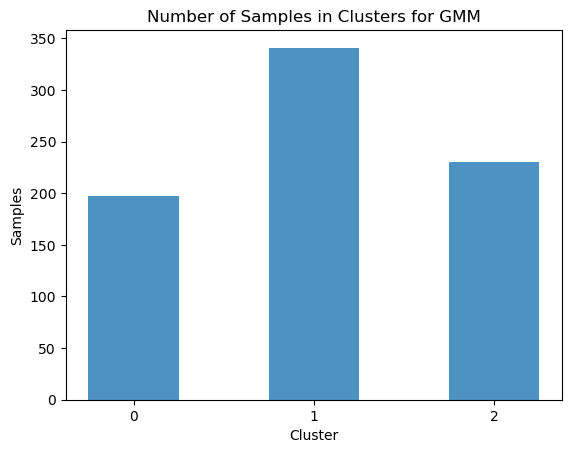

In [83]:
n = 3
gmm = GaussianMixture(n_components=n, covariance_type='full')
gmm.fit(X)
gmm_preds = gmm.predict(X)
plt.figure()
plt.grid()
plt.hist(gmm_preds, bins=np.arange(0, n + 1) - 0.5, rwidth=0.5, zorder=2, alpha=0.8)
plt.xticks(np.arange(0, n))
plt.xlabel('Cluster')
plt.ylabel('Samples')
plt.title('Number of Samples in Clusters for GMM')
plt.grid()

#### 2. Apply the dimensionality reduction algorithms to the two datasets and describe what you see.

PCA

[ 44.3  63.3  72.7  79.3  84.8  88.8  91.1  92.7  94.1  95.3  96.3  97.2
  98.   98.5  98.8  99.1  99.3  99.5  99.7  99.8  99.9 100.  100.1 100.2
 100.3 100.3 100.3 100.3 100.3 100.3]
Total Time: 0.004 seconds
Total Number of Features: 30
30 total features:
Best Number of PCA Components: 10


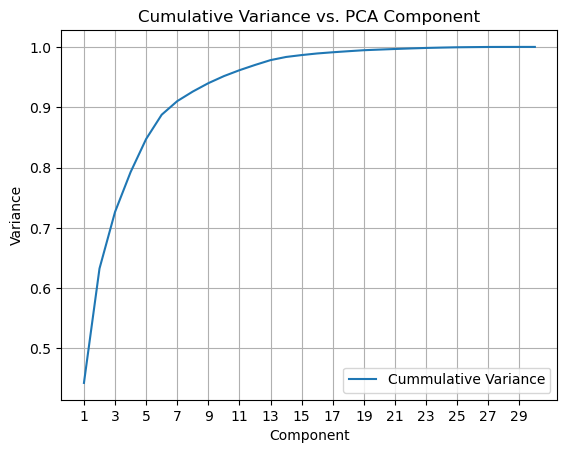

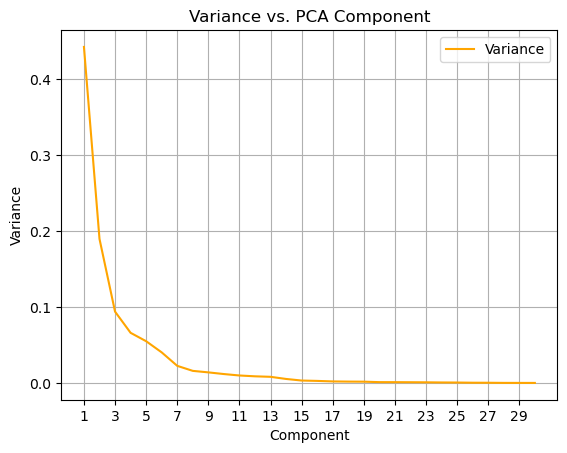

In [113]:
from time import time

pca = PCA(n_components = X.shape[1], random_state=seed)
start = time()
pca.fit(X)
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
end = time() - start
print(var)
print('Total Time: %.3f seconds' % end)
numComponents = np.argmax(var>95) + 1
print('Total Number of Features:', X.shape[1])    
print('%s total features:' %(X.shape[1]))
print('Best Number of PCA Components: %d' % numComponents)

plt.figure()
plt.grid()
plt.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), np.cumsum(pca.explained_variance_ratio_), label='Cummulative Variance')
plt.xticks(np.arange(1, pca.explained_variance_ratio_.size + 1, 2))
plt.xlabel('Component')
plt.ylabel('Variance')
plt.title('Cumulative Variance vs. PCA Component')
plt.legend()

plt.figure()
plt.grid()
plt.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), pca.explained_variance_ratio_, label='Variance', color = 'orange')
plt.xticks(np.arange(1, pca.explained_variance_ratio_.size + 1, 2))
plt.xlabel('Component')
plt.ylabel('Variance')
plt.title('Variance vs. PCA Component')
plt.legend()


ICA

Total Time: 1.154 seconds
Total Number of Features: 30
30 total features:
Best Number of ICA Componentss: 11


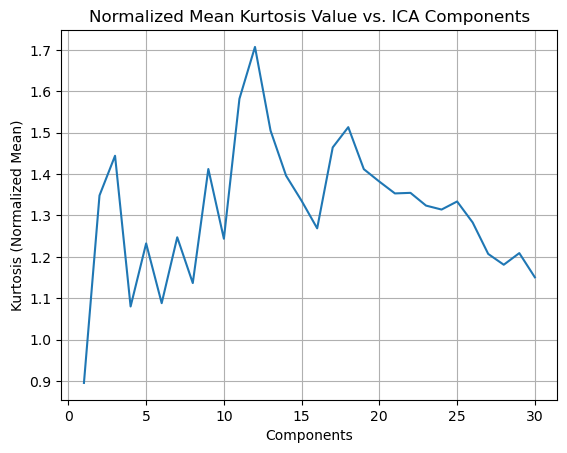

In [119]:
start = time()
kurtosis_values = []
dimensions = X.shape[1]+1
for i in range(1, dimensions):
    ica = FastICA(n_components = i, random_state = seed).fit_transform(X)
    kur = scipy.stats.kurtosis(ica)
    kurtosis_values.append(np.mean(kur)/i)
kurtosis_values = np.array(kurtosis_values)
end = time() - start
optimalComponents = np.argmax(kurtosis_values)

print('Total Time: %.3f seconds' % end)
print('Total Number of Features:', X.shape[1])    
print('%s total features:' %(X.shape[1]))
print('Best Number of ICA Componentss: %d' % optimalComponents)

plt.plot(np.arange(1, dimensions), kurtosis_values)
plt.xlabel('Components')
plt.ylabel('Kurtosis (Normalized Mean)')
plt.grid()
plt.title('Normalized Mean Kurtosis Value vs. ICA Components')
plt.show()


Randomized Projections

Total Number of Features: 30
Best Number of RP Components: 2
Total Time: 2.105 seconds


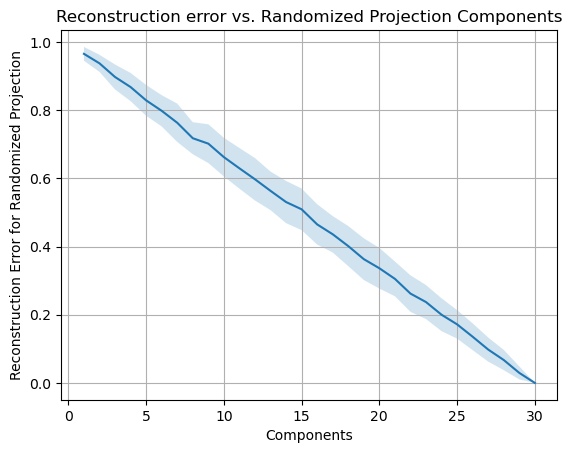

In [127]:
start = time()
dimensions = X.shape[1]+1
reconstruction_error = []
reconstruction_variance = []

for i in range(1, dimensions):
    mean_mse = []
    for j in range(0,100):
        rp = GaussianRandomProjection(n_components=i)
        rp = rp.fit(X)
        w = rp.components_
        p = pinv(w)
        reconstructed = ((p@w)@(X.T)).T
        mean_mse.append(mean_squared_error(X, reconstructed))
    reconstruction_variance.append(np.std(mean_mse))
    reconstruction_error.append(np.mean(mean_mse))

reconstruction_error = np.array(reconstruction_error)
optimalComponents = np.argmax(reconstruction_error)
end = time() - start
 
print('Total Number of Features:', X.shape[1])
print('Best Number of RP Components:', optimalComponents+2)
print('Total Time: %.3f seconds' % end)

plt.plot(np.arange(1,dimensions),reconstruction_error)
plt.fill_between(np.arange(1,dimensions),reconstruction_error - reconstruction_variance, reconstruction_error + reconstruction_variance, alpha=0.2)
plt.xlabel('Components')
plt.ylabel('Reconstruction Error for Randomized Projection')
plt.title('Reconstruction error vs. Randomized Projection Components')
plt.grid()
plt.show()

Univariate Feature Selection

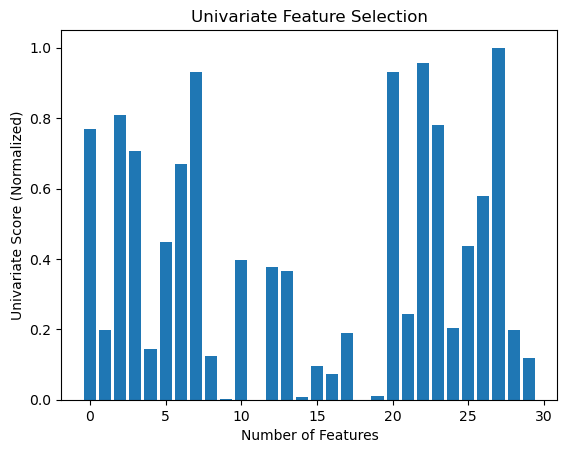

Total Time: 0.185 seconds


In [141]:
from sklearn.feature_selection import SelectKBest, f_classif
from time import time 
start = time()
kBest = SelectKBest(f_classif, k=4)
kBest.fit(X, y)
scores = kBest.pvalues_
scores[np.isnan(scores)]=0 # get rid of NaN's
scores += 1e-308           # get rid of zero values
scores = -np.log10(scores)
scores /= scores.max()

plt.title('Univariate Feature Selection')
plt.ylabel('Univariate Score (Normalized)')
plt.xlabel('Number of Features')
plt.grid(alpha=0)
plt.bar(np.arange(X.shape[-1]), scores)
plt.show()

end = time() - start
print('Total Time: %.3f seconds' % end)

#### Clustering & Demensionality Reduction
datasets 2  /
clustering 2  /
dimensionality reductions 4  /
total 16 problems

In [31]:
from time import time
# Run all kmeans and plot results
set_range = range(2,50)

def compare_kmeans(datasets):
    # Loop through all datasets
    all_sse = []
    all_scores = []
    all_methods = []
    for d in datasets:
        data   = d[1]
        sse    = []
        scores = []
        
        # try different cluster sizes
        for i in set_range:
            kmeans = KMeans(n_clusters=i,init='k-means++', random_state= seed)
            kmeans.fit(data)
            sse.append(kmeans.inertia_)
            
            kmeans_labels = kmeans.predict(data)
            scores.append(silhouette_score(data, kmeans_labels))
            
        all_sse.append(sse)
        all_scores.append(scores)
        all_methods.append(d[0])
                    
    
    plt.plot()
    for i,sse in enumerate(all_sse):
        plt.plot(set_range, sse,  label=all_methods[i])
    plt.title("Sum of Squares vs. Number of Clusters")
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum Square Error')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot()
    for i, score in enumerate(all_scores):
        plt.plot(set_range, score, label=all_methods[i])
    plt.title("Silhouette Score vs. Number of Clusters")
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()
    
def compare_em(datasets):
    # Loop through all datasets
    all_aic     = []
    all_bic     = []
    all_scores  = []
    all_dims    = []
    all_methods = []
    for d in datasets:
        data   = d[1]
        dimensions = data.shape[1] + 1
        all_dims.append(list(range(2,dimensions)))
        
        aic    = []
        bic    = []
        scores = []
        
        for i in range(2, dimensions):
            gmm = GaussianMixture(n_components=i, random_state= seed)
            gmm.fit(data)
            aic.append(gmm.aic(data))
            bic.append(gmm.bic(data))
        
            gmm_labels = gmm.predict(data)
            scores.append(silhouette_score(data, gmm_labels))
        
        all_aic.append(aic)
        all_bic.append(bic)
        all_scores.append(scores)
        all_methods.append(d[0])


    
    plt.plot()
    for i,aic in enumerate(all_aic):
        plt.plot(all_dims[i], aic, label=all_methods[i])
    plt.title("AIC vs. Number of Components")
    plt.xlabel('Number of Components')
    plt.ylabel('AIC')
    plt.grid()
    plt.legend()
    plt.show()
    

    plt.plot()
    for i,bic in enumerate(all_bic):
        plt.plot(all_dims[i], bic, label=all_methods[i])
    plt.title("BIC Score vs. Number of Components")
    plt.xlabel('Number of Components')
    plt.ylabel('BIC')
    plt.grid()
    plt.legend()
    plt.show()
    

    plt.plot()
    for i,score in enumerate(all_scores):
        plt.plot(all_dims[i], score, label=all_methods[i])
    plt.title("Silhouette Score vs. Number of Components")
    plt.xlabel('Number of Components')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.grid()
    plt.legend()
    plt.show()
    
    
def bench_kmeans(estimator, labels, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_, metric='euclidean')))
   
def bench_em(estimator, labels, name, data):
    t0 = time()
    estimator.fit(data)
    gmm_labels = estimator.predict(data)
    print('%-9s\t%.2fs\t%i\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.aic(data), estimator.bic(data),
             metrics.homogeneity_score(labels, gmm_labels),
             metrics.completeness_score(labels, gmm_labels),
             metrics.v_measure_score(labels, gmm_labels),
             metrics.adjusted_rand_score(labels, gmm_labels),
             metrics.adjusted_mutual_info_score(labels,  gmm_labels),
             metrics.silhouette_score(data, gmm_labels, metric='euclidean')))
    

In [28]:
# Demensionality Reduction 
try_PCA = PCA(n_components=9, random_state=seed).fit_transform(X)
try_ICA = FastICA(n_components=8, random_state=seed).fit_transform(X)
try_RP = GaussianRandomProjection(n_components=8, random_state=seed).fit_transform(X)
try_UPS = SelectKBest(f_classif, k=4).fit_transform(X, y)

dataset = []
dataset.append(['None', X])
dataset.append(['PCA', try_PCA])
dataset.append(['Fast_ICA', try_ICA])
dataset.append(['RP',  try_RP])
dataset.append(['UFS', try_UPS])

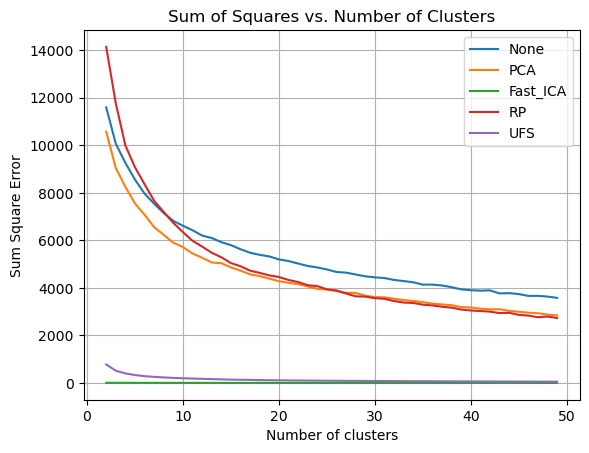

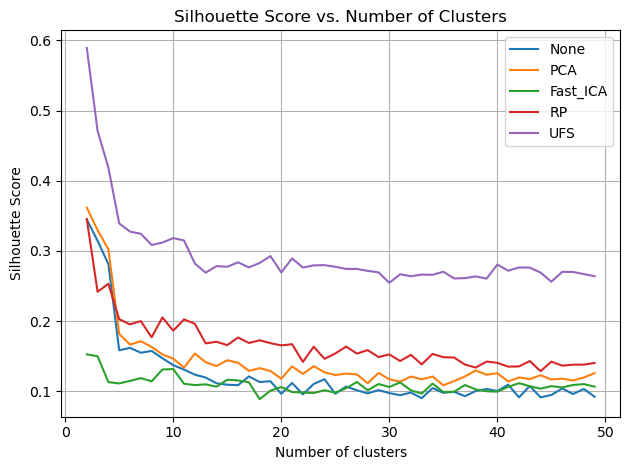

init		time	inertia	homog	compl	v-meas	ARI	AMI	silhouette
_____________________________________________________________________________________
Original 	0.05s	11595	0.525	0.540	0.532	0.654	0.532	0.343
PCA-based	0.03s	10570	0.544	0.565	0.555	0.671	0.554	0.362
ICA-based	0.05s	7	0.686	0.717	0.701	0.786	0.700	0.149
RP-based 	0.04s	14136	0.021	0.024	0.022	0.054	0.021	0.345
UFS-based	0.03s	779	0.667	0.715	0.690	0.748	0.690	0.589


In [30]:
# Create k-means plots
compare_kmeans(dataset)

# Create k-means benchmark table
print('init\t\ttime\tinertia\thomog\tcompl\tv-meas\tARI\tAMI\tsilhouette')
print(85*'_')
bench_kmeans(KMeans(init='k-means++', n_clusters=2), labels=y, name="Original",  data=X)
bench_kmeans(KMeans(init='k-means++', n_clusters=2), labels=y, name="PCA-based", data=try_PCA)
bench_kmeans(KMeans(init='k-means++', n_clusters=2), labels=y, name="ICA-based", data=try_ICA)
bench_kmeans(KMeans(init='k-means++', n_clusters=2), labels=y, name="RP-based",  data=try_RP)
bench_kmeans(KMeans(init='k-means++', n_clusters=2), labels=y, name="UFS-based", data=try_UPS)

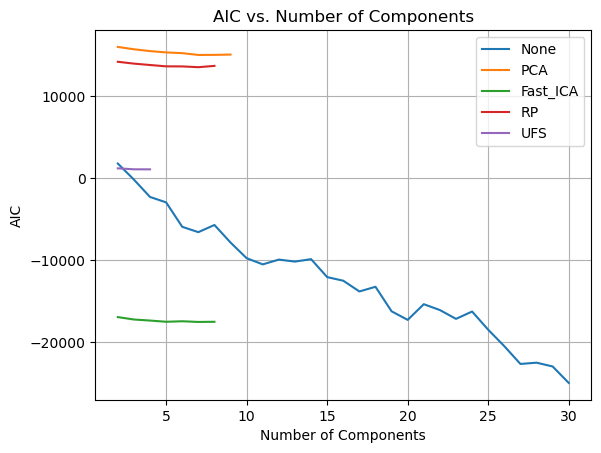

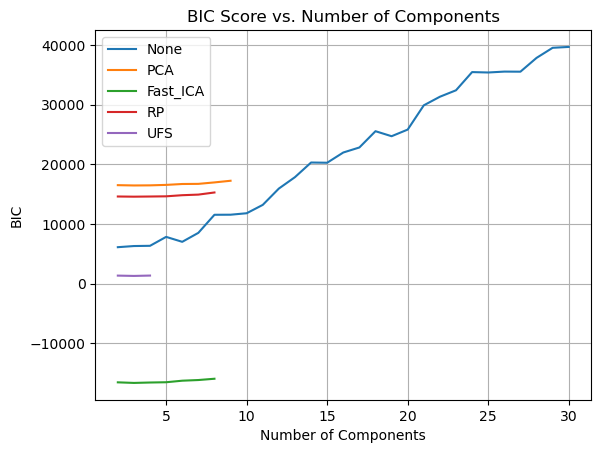

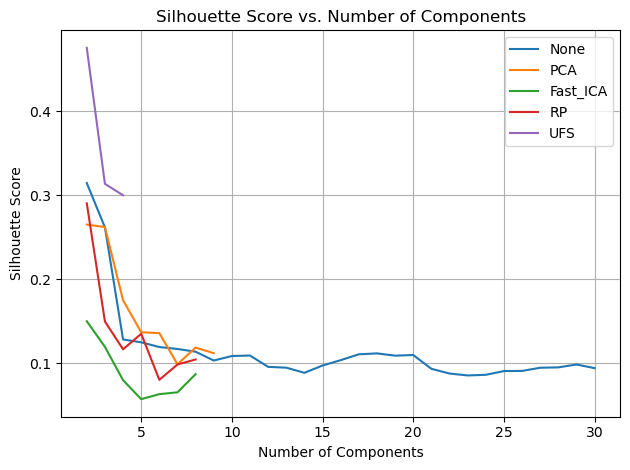

init		time	aic	bic	homog	compl	v-meas	ARI	AMI	silhouette
_____________________________________________________________________________________
Original 	0.07s	-5705	11526	0.741	0.253	0.377	0.237	0.374	0.114
PCA-based	0.07s	15043	16950	0.656	0.244	0.356	0.276	0.352	0.119
ICA-based	0.05s	-17515	-15955	0.598	0.234	0.336	0.350	0.333	0.087
RP-based 	0.05s	13703	15263	0.427	0.157	0.229	0.202	0.225	0.105
UFS-based	0.05s	981	1498	0.682	0.224	0.337	0.174	0.334	0.108


In [32]:
# Create k-means plots
compare_em(dataset)

# Create k-means benchmark table
print('init\t\ttime\taic\tbic\thomog\tcompl\tv-meas\tARI\tAMI\tsilhouette')
print(85*'_')
bench_em(GaussianMixture(n_components=8, random_state= seed), labels=y, name="Original",  data=X)
bench_em(GaussianMixture(n_components=8, random_state= seed), labels=y, name="PCA-based", data=try_PCA)
bench_em(GaussianMixture(n_components=8, random_state= seed), labels=y, name="ICA-based", data=try_ICA)
bench_em(GaussianMixture(n_components=8, random_state= seed), labels=y, name="RP-based",  data=try_RP)
bench_em(GaussianMixture(n_components=8, random_state= seed), labels=y, name="UFS-based", data=try_UPS)

#### 4. Neural Network & Dimensionality Reduction

In [39]:
def plot_learning_curve(clf, X, y, title='Learning Curve'):
    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(clf, X, y, cv = 5, scoring='accuracy',  
                                                                                    train_sizes=np.linspace(0.01, 1.0, 20), n_jobs=-1, 
                                                                                    return_times = True, 
                                                                                    random_state = seed)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(1)
    plt.plot(train_sizes, train_mean,  label="Training score")
    plt.plot(train_sizes, test_mean,  label="CV score")


    plt.title(title)
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy"), plt.legend(loc="best")
    plt.tight_layout()
    plt.grid()
    plt.show()
    
    train_times_mean = np.mean(fit_times, axis=1)
    train_times_std  = np.std(fit_times, axis=1)
    
    plt.figure(2)
    plt.plot(train_sizes, train_times_mean)
    plt.title('Training Scalability')
    plt.xlabel('Training Set Size')
    plt.ylabel('Fit Time (s)')
    plt.grid()
    plt.show()
    

def calculate_null_accuracy(y):
    vals, counts = np.unique(y, return_counts=True)
    
    norm = counts / np.sum(counts)
    
    return max(norm)

In [40]:
# Demensionality Reduction 
try_PCA = PCA(n_components=9, random_state=seed).fit_transform(X)
try_ICA = FastICA(n_components=8, random_state=seed).fit_transform(X)
try_RP = GaussianRandomProjection(n_components=8, random_state=seed).fit_transform(X)
try_UPS = SelectKBest(f_classif, k=4).fit_transform(X, y)

dataset = []
dataset.append(['None', X])
dataset.append(['PCA', try_PCA])
dataset.append(['Fast_ICA', try_ICA])
dataset.append(['RP',  try_RP])
dataset.append(['UFS', try_UPS])

Neural Net model fit in 35.076 s
Best Score: 0.972 using {'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'solver': 'sgd'}


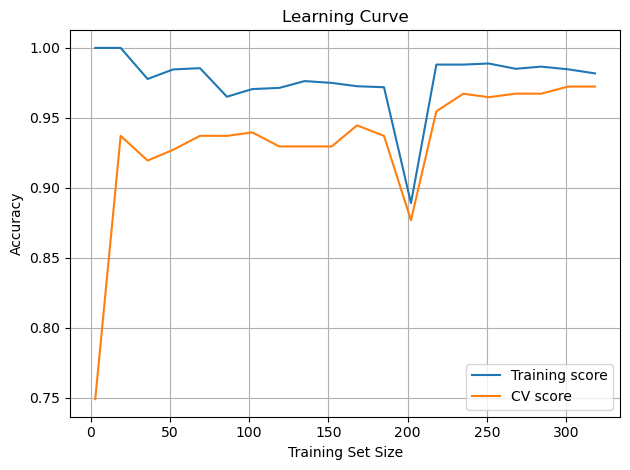

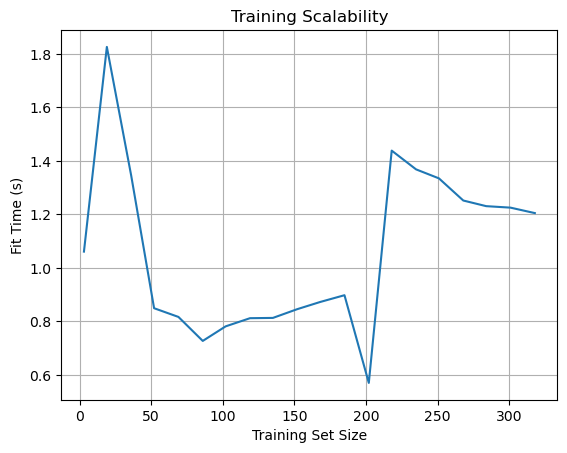

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        68
           1       0.96      0.99      0.98       103

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171

Neural Net model fit in 30.841 s
Best Score: 0.975 using {'hidden_layer_sizes': (30, 20), 'learning_rate': 'constant', 'solver': 'adam'}


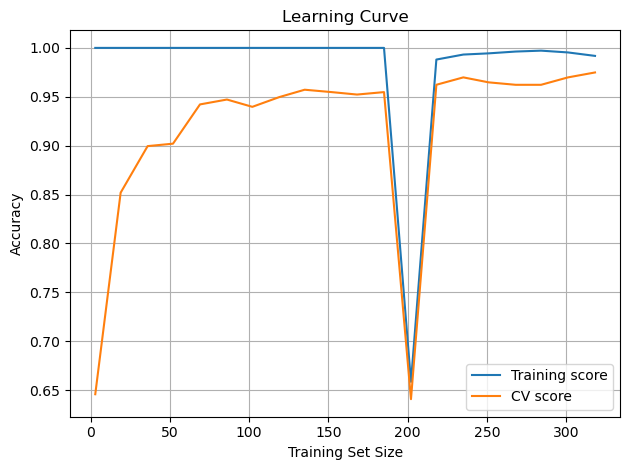

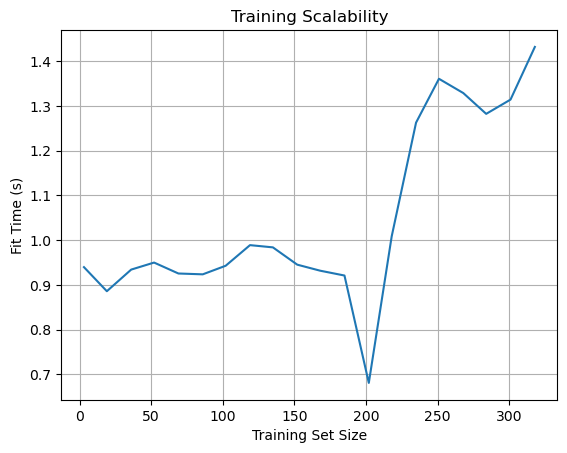

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        68
           1       0.97      0.98      0.98       103

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171

Neural Net model fit in 30.070 s
Best Score: 0.970 using {'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}


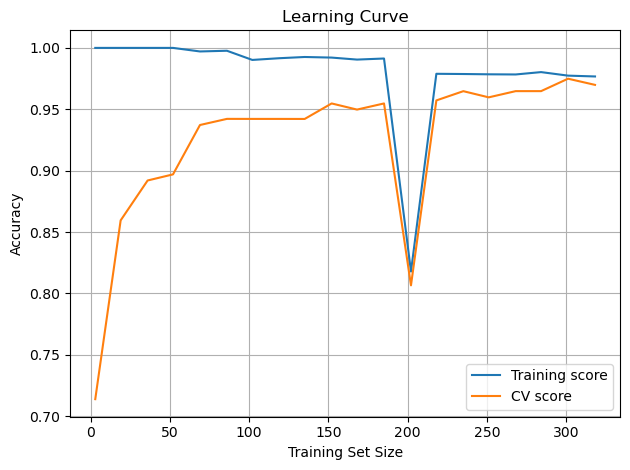

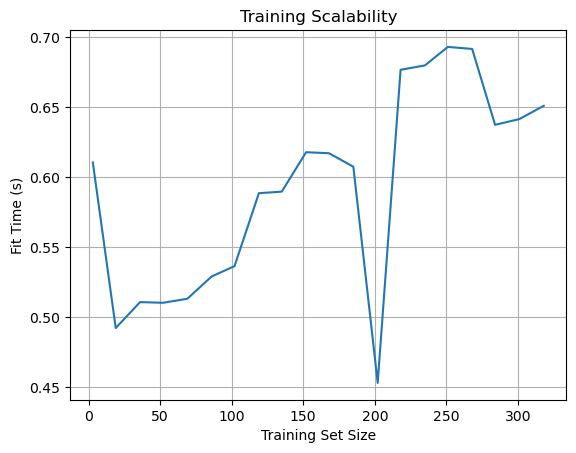

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        68
           1       0.98      1.00      0.99       103

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



/Users/irenekim/opt/anaconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/irenekim/opt/anaconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/irenekim/opt/anaconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549

Neural Net model fit in 42.127 s
Best Score: 0.909 using {'hidden_layer_sizes': (40, 10), 'learning_rate': 'constant', 'solver': 'adam'}


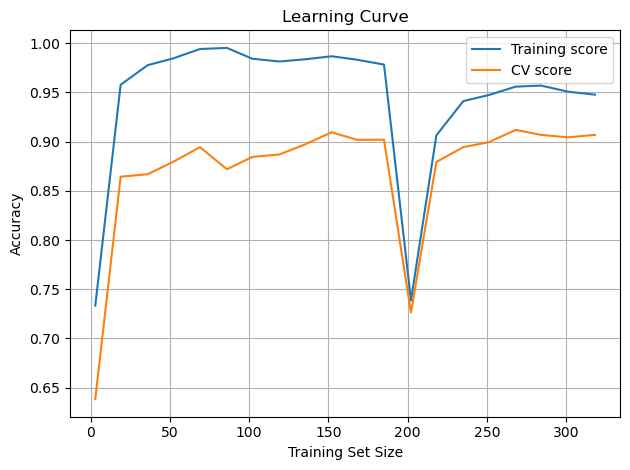

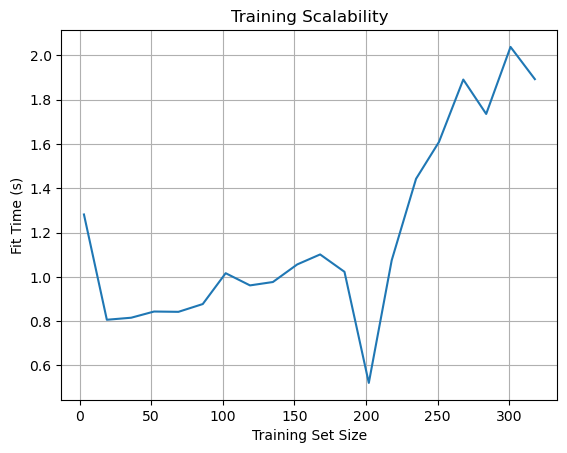

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        68
           1       0.93      0.93      0.93       103

    accuracy                           0.92       171
   macro avg       0.91      0.91      0.91       171
weighted avg       0.92      0.92      0.92       171

Neural Net model fit in 15.596 s
Best Score: 0.937 using {'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'solver': 'adam'}


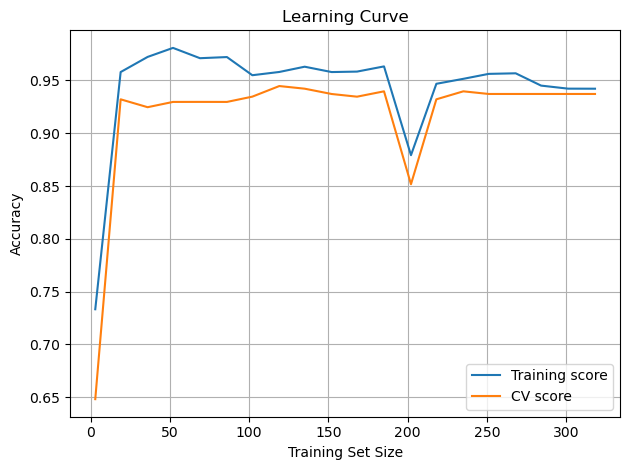

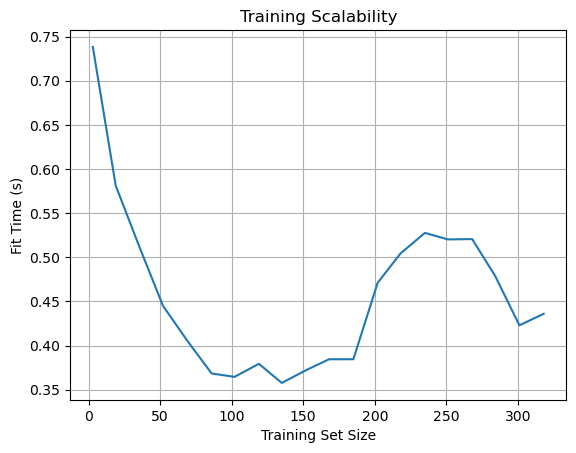

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        68
           1       0.96      1.00      0.98       103

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.98       171
weighted avg       0.98      0.98      0.98       171

Results
Data:  None
	Time:    35.076096057891846
	Score:   0.9723734177215191
	Params:  {'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'solver': 'sgd'}
Data:  PCA
	Time:    30.84091091156006
	Score:   0.974873417721519
	Params:  {'hidden_layer_sizes': (30, 20), 'learning_rate': 'constant', 'solver': 'adam'}
Data:  Fast_ICA
	Time:    30.06950807571411
	Score:   0.969873417721519
	Params:  {'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}
Data:  RP
	Time:    42.1266131401062
	Score:   0.9094936708860759
	Params:  {'hidden_layer_sizes': (40, 10), 'learning_rate': 'constant', 'solver': 'adam'}
Data:  UFS
	Time:    15.5955808162

In [41]:
from sklearn.metrics import plot_confusion_matrix, classification_report

solvers = ['sgd', 'lbfgs', 'adam', 'adadelta']
layers = [(10,), (20,), (30,), (40,), (10,10), (20, 10), (20,20), (30, 10), (30, 20), (40,10), (40,20)]
learning_rates = ['constant', 'invscaling']
parameters = {'solver': solvers, 'learning_rate': learning_rates, 'hidden_layer_sizes': layers}

test_size=0.2
nn_data = []

for d in dataset:
    dataName = d[0]

    X = d[1]
    y = y

    X = scale(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= seed)
    
    clf = GridSearchCV(MLPClassifier(max_iter=2000, alpha=1, random_state= seed), parameters, cv=5, n_jobs=-1 , scoring='accuracy')
                
    t0 = time()
    clf.fit(X_train, y_train)
    nn_time = time() - t0
    
    print("Neural Net model fit in %.3f s" % nn_time)
    print('Best Score: %.3f using %r' % (clf.best_score_, clf.best_params_))
    
    nn = MLPClassifier(learning_rate=clf.best_params_["learning_rate"],
                       solver=clf.best_params_["solver"],
                       hidden_layer_sizes=clf.best_params_["hidden_layer_sizes"],
                       max_iter=2000,
                       alpha=1,
                       random_state=seed)
    
    plot_learning_curve(nn, X_train, y_train)

    nn.fit(X_train, y_train)
    nn_pred = nn.predict(X_test)
    calculate_null_accuracy(y)
    print(classification_report(y_test, nn_pred))
    
    results = {
        "classifier": nn,
        "dataset": dataName,
        "time":    nn_time,
        "score":   clf.best_score_,
        "params":  clf.best_params_
    }
    
    nn_data.append(results)

print('Results')
for res in nn_data:
    print('\tTime:   ', res["time"])
    print('\tScore:  ', res["score"])
    print('\tParams: ', res["params"])

#### 5. Neural Network & Dimensionality Reduction & Clustering

In [ ]:
import time
# load dataset again
bc = load_breast_cancer()
db = pd.read_csv('./data/diabetes.csv')

X = bc.data
y = bc.target
df = pd.DataFrame(data=X, columns=bc.feature_names)
df['label'] = y

X =  scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = seed)

Best params for neural network: {'alpha': 1.0, 'hidden_layer_sizes': 7}
Time to train: 91.22638702392578
Accuracy for best neural network: 0.9912280701754386
Time to infer: 0.00044083595275878906
[[40  1]
 [ 0 73]]


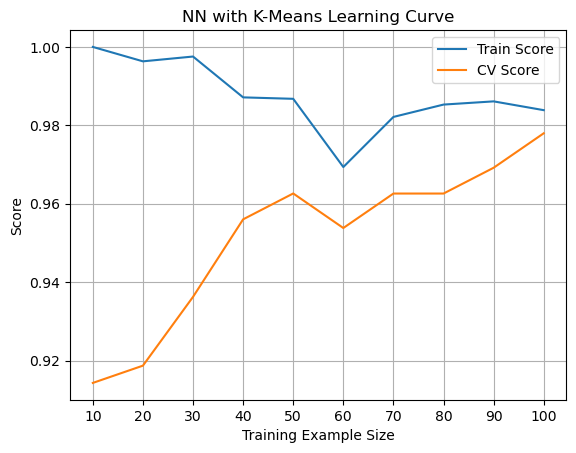

: 

In [ ]:
# K-means
k = 6
k_means_clf = KMeans(n_clusters=k, random_state= seed)
k_means_clf.fit_transform(X)
kmeans_X = np.append(X, k_means_clf.fit_transform(X), 1)
X_KMeans_train, X_KMeans_test, y_KMeans_train, y_KMeans_test = train_test_split(kmeans_X, y, test_size=0.2, random_state=seed)

clf = MLPClassifier(random_state=seed, max_iter=2000)
param_grid = {'alpha': np.logspace(-3,3,7), 'hidden_layer_sizes': np.arange(1, 10, 1)}
clf_nn = GridSearchCV(clf, param_grid=param_grid, cv= 5)

start_time = time.time()
clf_nn.fit(X_KMeans_train, y_KMeans_train)
end_time = time.time()
time_train = end_time-start_time
print("Best params for neural network:",clf_nn.best_params_)
print("Time to train:",time_train)

start_time = time.time()
classifier_accuracy = accuracy_score(y_KMeans_test, clf_nn.predict(X_KMeans_test))
end_time = time.time()
time_infer = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy)
print("Time to infer:",time_infer)
print(confusion_matrix(y_KMeans_test, clf_nn.predict(X_KMeans_test)))

# With best hyperparameter configuration
classifier_neural_network_learning = MLPClassifier(random_state= seed, max_iter=2000, 
                                                   hidden_layer_sizes=clf_nn.best_params_['hidden_layer_sizes'], 
                                                   alpha=clf_nn.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_KMeans_train, y_KMeans_train, train_sizes=np.linspace(0.1,1.0,10), cv= 5)

plt.figure()
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("NN with K-Means Learning Curve")
plt.xlabel("Training Example Size")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.show()

Best params for neural network: {'alpha': 10.0, 'hidden_layer_sizes': 4}
Time to train: 142.91239595413208
Accuracy for best neural network: 0.9912280701754386
Time to infer: 0.00038504600524902344
[[40  1]
 [ 0 73]]


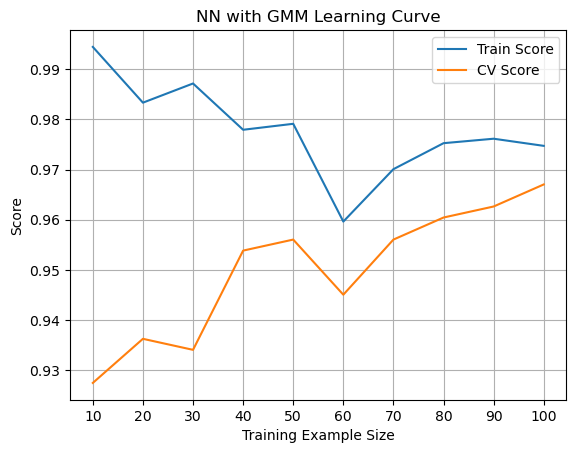

In [55]:
# EM
k = 2
gmm = mixture.GaussianMixture(n_components= k , covariance_type='full')
gmm.fit(X)
gmm.predict_proba(X)

gmm_X = np.append(X, gmm.predict_proba(X), 1)
X_GMM_train, X_GMM_test, y_GMM_train, y_GMM_test = train_test_split(gmm_X, y, test_size=0.2, random_state=seed)

clf_nn = MLPClassifier(random_state=42, max_iter=2000)
param_grid = {'alpha': np.logspace(-3,3,7), 'hidden_layer_sizes': np.arange(1, 10, 1)}
clf_nn_best = GridSearchCV(clf_nn, param_grid=param_grid, cv=5)

start_time = time.time()
clf_nn_best.fit(X_GMM_train, y_GMM_train)
end_time = time.time()
time_train = end_time-start_time
print("Best params for neural network:",clf_nn_best.best_params_)
print("Time to train:",time_train)

start_time = time.time()
classifier_accuracy = accuracy_score(y_GMM_test, clf_nn_best.predict(X_GMM_test))
end_time = time.time()
time_infer = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy)
print("Time to infer:",time_infer)
print(confusion_matrix(y_GMM_test, clf_nn_best.predict(X_GMM_test)))


# With best hyperparameter configuration
classifier_neural_network_learning = MLPClassifier(random_state= seed, max_iter=2000, 
                                                   hidden_layer_sizes=clf_nn_best.best_params_['hidden_layer_sizes'], 
                                                   alpha=clf_nn_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_GMM_train, y_GMM_train, train_sizes=np.linspace(0.1,1.0,10), cv=5)

plt.figure()
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("NN with GMM Learning Curve")
plt.xlabel("Training Example Size")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.show()